# Generate A/B compartments from Hi-C matrices 
## from GSE99363

by Pu Zheng

2022.05.03

Data from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE99363

Citation: https://www.nature.com/articles/ng.3906

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

16436


In [2]:
import pandas as pd

# 0. Load processed hic_matrices

In [4]:
hic_save_folder = r'W:\HiC_cortex\hic_map_cortex_20kb'
hic_reg_df = pd.read_csv(os.path.join(hic_save_folder, 'filtered_regions.csv'))
hic_reg_df

,chr,start,end,name
0,1,0,20000,1
1,1,20000,40000,2
2,1,40000,60000,3
3,1,60000,80000,4
4,1,80000,100000,5
...,...,...,...,...
127731,20,91660000,91680000,136284
127732,20,91680000,91700000,136285
127733,20,91700000,91720000,136286
127734,20,91720000,91740000,136287


In [5]:
save_genomic_resolution = '40k'

AB_savefile = os.path.join(hic_save_folder, 
                           f'AB_comp_{save_genomic_resolution}.hdf5')

In [59]:
chr_2_RegStarts = {}
chr_2_PC1 = {}

with h5py.File(AB_savefile, 'r') as _f:
    for _chr_name in _f.keys():
        if 'chr' in _chr_name:
            _chr = int(_chr_name.split('chr')[1])
            print(_chr)
            chr_2_RegStarts[_chr] = _f[_chr_name]['reg_starts'][:]
            chr_2_PC1[_chr] = _f[_chr_name]['pc1_vector'][:]


1
10
11
12
13
14
15
16
17
18
19
2
3
4
5
6
7
8
9


# Load codebook

In [8]:
decoder_folder = r'\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder'
codebook_filename = os.path.join(decoder_folder, 'merged_codebook.csv')
codebook = pd.read_csv(codebook_filename)
codebook

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,1:3740000-3760000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6240000-6260000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740000-8760000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1:11240000-11260000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1:13740000-13760000,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,X:101910335-102015609,2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1952,X:136772307-136851006,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1953,X:140481839-140547985,2051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1954,X:167122110-167191320,2052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
_chr

1

In [28]:
_reg_starts[18],_mid

(3720000, 3750000.0)

In [104]:
chr_2_rids = {}
chr_2_SelPC1 = {}
for _chr in sorted(chr_2_RegStarts):
    print(_chr)
    _chr_rids = []
    _chr_pc1 = []
    chr_codebook = codebook.loc[codebook['chr']==str(_chr)].sort_values('chr_order')
    # find matched starts
    _reg_starts = chr_2_RegStarts[_chr]
    for _name in chr_codebook['name']:

        _start,_end = _name.split(':')[1].split('-')
        _mid = (int(_start) + int(_end)) /2 
        _matched_rind = np.argmin(np.abs(_reg_starts+20000-_mid))
        
        _chr_reg_df = hic_reg_df[hic_reg_df['chr']==_chr]

        _name0 = _chr_reg_df.loc[_chr_reg_df['start']==_reg_starts[_matched_rind], 'name'].values
        _name1 = _chr_reg_df.loc[_chr_reg_df['start']==_reg_starts[_matched_rind]+20000, 'name'].values
        _matched_rids = np.concatenate([_name0,_name1])
        # append
        _chr_rids.append(_matched_rids)
        _chr_pc1.append(chr_2_PC1[_chr][_matched_rind])
    # add to key
    chr_2_SelPC1[_chr] = np.array(_chr_pc1)
    chr_2_rids[_chr] = np.array(_chr_rids)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,compartment
0,1:3740000-3760000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1:6240000-6260000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1:8740000-8760000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
988,1:9600471-9656458,1063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
989,1:9749317-9845402,1064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,1:189480922-189543419,1136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1062,1:189866129-189938237,1137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
75,1:191240000-191260000,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1063,1:193075619-193133645,1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [141]:
new_codebook.iloc[_indices]a

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,compartment
0,1:3740000-3760000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1:6240000-6260000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1:8740000-8760000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
988,1:9600471-9656458,1063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
989,1:9749317-9845402,1064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,1:189480922-189543419,1136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1062,1:189866129-189938237,1137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
75,1:191240000-191260000,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1063,1:193075619-193133645,1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [168]:
all_chr_codebooks = []
for _chr, _chr_A in sorted(chr_2_A.items()):
    print(_chr)
    _chr_codebook = codebook.loc[codebook['chr']==str(_chr)].sort_values('chr_order')
    _chr_codebook['compartment'] = _chr_A
    all_chr_codebooks.append(_chr_codebook)
# append X and Y
_x_codebook = _chr_codebook = codebook.loc[codebook['chr']=='X'].sort_values('chr_order')
_x_codebook['compartment'] = -1
_y_codebook = _chr_codebook = codebook.loc[codebook['chr']=='Y'].sort_values('chr_order')
_y_codebook['compartment'] = -1
all_chr_codebooks.append(_x_codebook)
all_chr_codebooks.append(_y_codebook)

new_codebook = pd.concat(all_chr_codebooks)
new_codebook

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,compartment
0,1:3740000-3760000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6240000-6260000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740000-8760000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
988,1:9600471-9656458,1063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
989,1:9749317-9845402,1064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,X:166240000-166260000,1059,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1954,X:167122110-167191320,2052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
986,X:168740000-168760000,1060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1955,X:169962881-170032477,2053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0


In [154]:
# Assign new column called compartment
new_codebook = codebook.copy()
new_codebook['compartment'] = -1

for _chr, _chr_A in chr_2_A.items():
    _indices = codebook.loc[codebook['chr']==str(_chr)].sort_values('chr_order').index
    new_codebook.loc[_indices,'compartment'] = _chr_A

In [169]:
# save
save_codebook_filename = os.path.join(decoder_folder, 'merged_codebook_compartment.csv')
new_codebook.to_csv(save_codebook_filename, index=False)

In [157]:
print(decoder_folder)

\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\Decoder


In [99]:
all_chrs = np.concatenate([_chr*np.ones(len(_rids)) for _chr, _rids in chr_2_rids.items()])

In [68]:
all_rids = np.concatenate(list(chr_2_rids.values()))

(array([   0,    1,    2, ..., 1889, 1890, 1891]),
 array([   0,    1,    2, ..., 1889, 1890, 1891]))

In [109]:
np.transpose(matched_contacts)

array([[276.,   0.,   0., ...,   0.,   0.,   0.],
       [  2., 379.,   0., ...,   0.,   0.,   0.],
       [  2.,   2., 306., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 425.,   0.,   0.],
       [  0.,   0.,   0., ...,   6., 291.,   0.],
       [  0.,   0.,   0., ...,   0.,   2., 264.]])

In [113]:
final_contacts = matched_contacts + np.transpose(matched_contacts)
final_contacts[np.diag_indices(len(final_contacts))] = np.diag(matched_contacts)
#np.diag_indices(final_contacts)

In [121]:
trans_contacts = final_contacts.copy()
for _chr in np.unique(all_chrs):
    _chr_inds = np.where(all_chrs==_chr)[0]
    trans_contacts[_chr_inds, _chr_inds[:,np.newaxis]] = np.nan

In [216]:
chr_2_A = {}
for _chr in chr_2_SelPC1:
    _chr_A = np.zeros(len(chr_2_SelPC1[_chr]))
    
    _chr_inds = np.where(all_chrs==_chr)[0]
    _comp0_inds = np.where(chr_2_SelPC1[_chr] >=0)
    _comp1_inds = np.where(chr_2_SelPC1[_chr] <0)
    _comp0_mct = np.nanmean(trans_contacts[_chr_inds][_comp0_inds])
    _comp1_mct = np.nanmean(trans_contacts[_chr_inds][_comp1_inds])
    print(_chr, _comp0_mct, _comp1_mct)
    if _comp1_mct > _comp0_mct:
        _chr_A[_comp1_inds] = 1
    else:
        _chr_A[_comp0_inds] = 1
    print(np.mean(_chr_A))
    chr_2_A[_chr] = _chr_A

1 0.016551241343100733 0.009162982305640137
0.6013071895424836
2 0.021658431683776656 0.012819355421142908
0.46853146853146854
3 0.016597210163801585 0.009916156078684296
0.65
4 0.02287434161023326 0.01256583897667419
0.5
5 0.025319562327436342 0.014337190901984709
0.4824561403508772
6 0.01854411055760887 0.010481644339912057
0.6140350877192983
7 0.016346665376988926 0.023500289836907988
0.7553191489361702
8 0.021353196772191184 0.015241369431313566
0.6176470588235294
9 0.01859537110933759 0.026219739292364992
0.5882352941176471
10 0.018737070707871315 0.013915178799815828
0.6173913043478261
11 0.017029307526032236 0.02563783705361769
0.5142857142857142
12 0.015273364031389843 0.02237646587150446
0.5641025641025641
13 0.019959283900350493 0.014406250847825498
0.5638297872340425
14 0.02188829859940404 0.01264591439688716
0.6559139784946236
15 0.022877032233113687 0.015525881296526952
0.49333333333333335
16 0.026128888539455407 0.016444021947599273
0.56
17 0.0212783922992485 0.0275920566

In [127]:
codebook.loc[codebook['v']]

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,1:3740000-3760000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6240000-6260000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740000-8760000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1:11240000-11260000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1:13740000-13760000,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,X:101910335-102015609,2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1952,X:136772307-136851006,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1953,X:140481839-140547985,2051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1954,X:167122110-167191320,2052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
from tqdm import tqdm

In [91]:
%%time
matched_contacts = np.zeros([len(all_rids),len(all_rids)])

for _rids in tqdm(all_rids):
    # get all contacts
    _related_contacts = hic_raw_contacts[(hic_raw_contacts[:,0] == _rids[0]) \
                                         |  (hic_raw_contacts[:,1] == _rids[0])\
                                         |  (hic_raw_contacts[:,0] == _rids[1])\
                                         |  (hic_raw_contacts[:,1] == _rids[1])\
                                        ]
    for _l, _r, _ct in _related_contacts:
        if _l in all_rids and _r in all_rids:
            matched_contacts[np.where(all_rids==_l)[0], np.where(all_rids==_r)[0]] += _ct
    

100%|██████████████████████████████████████████████████████████████████████████████| 1892/1892 [11:15<00:00,  2.80it/s]

Wall time: 11min 15s


<IPython.core.display.Javascript object>


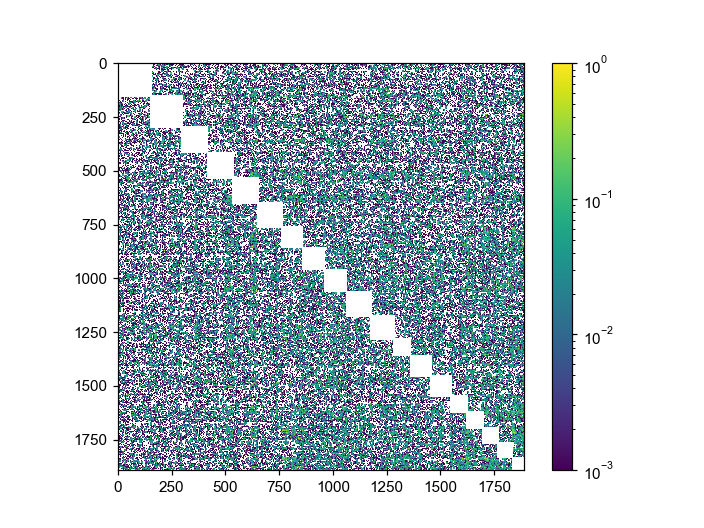

C:\Users\puzheng\AppData\Local\Temp/ipykernel_16436/947358290.py:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(trans_contacts, vmin=1e-3, vmax=1, norm=LogNorm())


In [122]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.figure(dpi=100)
plt.imshow(trans_contacts, vmin=1e-3, vmax=1, norm=LogNorm())
plt.colorbar()
plt.show()

# load all hic_contacts

In [31]:
%%time
hic_raw_folder = r'\\10.245.74.212\Chromatin_NAS_3\HiC_cortex'
hic_raw_fl = os.path.join(hic_raw_folder, 'hic_raw_map.npy')
# If load hic raw map (# n-by-3 array as bin-i; bin-j; contact count)
hic_raw_contacts = np.load(hic_raw_fl) # array as bin-i; bin-j; contact count

# If load hic region annotation (# n-by-4 array as chr;start;end;bin-name)
hic_reg_savename = os.path.join(hic_raw_folder, "hic_reg_annotation.npy")
hic_raw_regs = np.load(hic_reg_savename)

print(hic_raw_regs.shape)  # array as chr;start;end;bin-name

(250885, 4)
Wall time: 3.47 s


# partition AB

In [158]:
new_codebook

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,compartment
0,1:3740000-3760000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6240000-6260000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740000-8760000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1:11240000-11260000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1:13740000-13760000,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,X:101910335-102015609,2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1952,X:136772307-136851006,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1953,X:140481839-140547985,2051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1954,X:167122110-167191320,2052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0


In [189]:
A_inds = np.where(new_codebook['compartment'].values==1)[0]
B_inds = np.where(new_codebook['compartment'].values==0)[0]
AB_inds = np.concatenate([A_inds, B_inds])

In [200]:
plt.style.use('dark_background')

In [201]:
_type_matrix_file = os.path.join(r'\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\PostAnalysis\Nonnan_cutoff_100\Figures_Ex_Median_Trans_5000',
                                 r'trans-median_map_bychr_Astro.npy')
_type_matrix = np.load(_type_matrix_file)

<IPython.core.display.Javascript object>


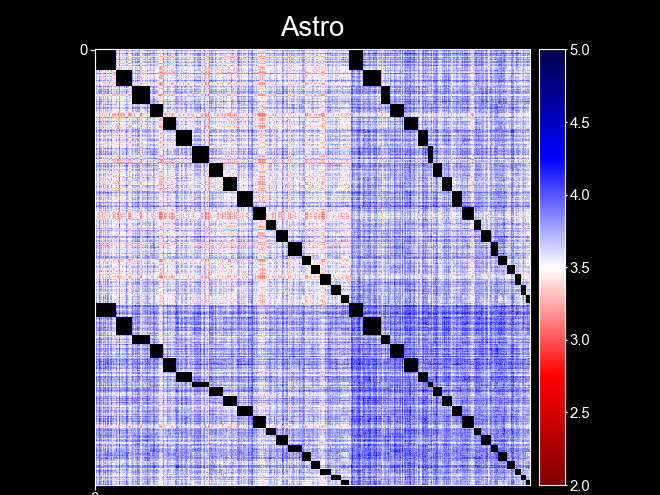

In [203]:
_fig, _ax = plt.subplots(figsize=(4,3), dpi=150)
_ax = ia.figure_tools.distmap.plot_distance_map(
    _type_matrix[AB_inds, AB_inds[:,np.newaxis]]/1000, 
    color_limits=[2,5],
    font_size=6.5,
    ax=_ax,)
_ax.set_title(f"Astro")
_fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, top=0.9, bottom=0.02)


In [204]:
_type_matrix_file = os.path.join(r'\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\PostAnalysis\Nonnan_cutoff_100\Figures_Ex_Median_Trans_5000',
                                 r'trans-median_map_bychr_Gluta.npy')
_type_matrix = np.load(_type_matrix_file)

<IPython.core.display.Javascript object>


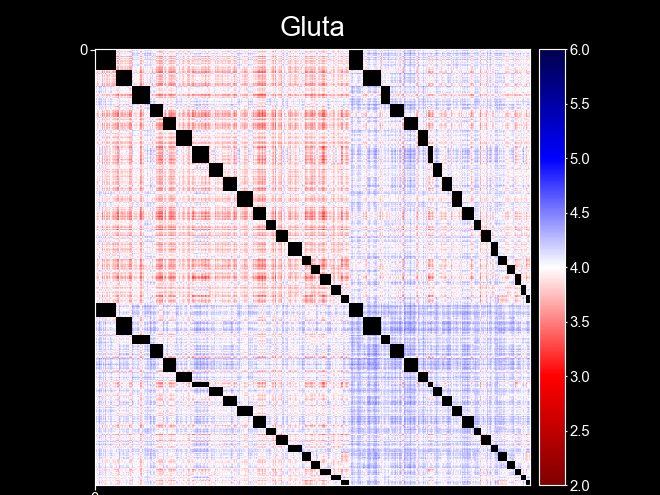

In [208]:
_fig, _ax = plt.subplots(figsize=(4,3), dpi=150)
_ax = ia.figure_tools.distmap.plot_distance_map(
    _type_matrix[AB_inds, AB_inds[:,np.newaxis]]/1000, 
    color_limits=[2,6],
    font_size=6.5,
    ax=_ax,)
_ax.set_title(f"Gluta")
_fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, top=0.9, bottom=0.02)


In [209]:
_type_matrix_file = os.path.join(r'\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\PostAnalysis\Nonnan_cutoff_100\Figures_Ex_Median_Trans_5000',
                                 r'trans-median_map_bychr_GABA.npy')
_type_matrix = np.load(_type_matrix_file)

<IPython.core.display.Javascript object>


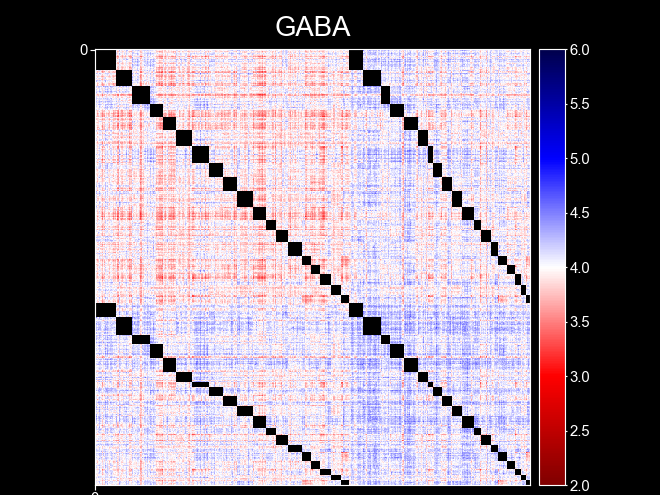

In [210]:
_fig, _ax = plt.subplots(figsize=(4,3), dpi=150)
_ax = ia.figure_tools.distmap.plot_distance_map(
    _type_matrix[AB_inds, AB_inds[:,np.newaxis]]/1000, 
    color_limits=[2,6],
    font_size=6.5,
    ax=_ax,)
_ax.set_title(f"GABA")
_fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, top=0.9, bottom=0.02)


<IPython.core.display.Javascript object>


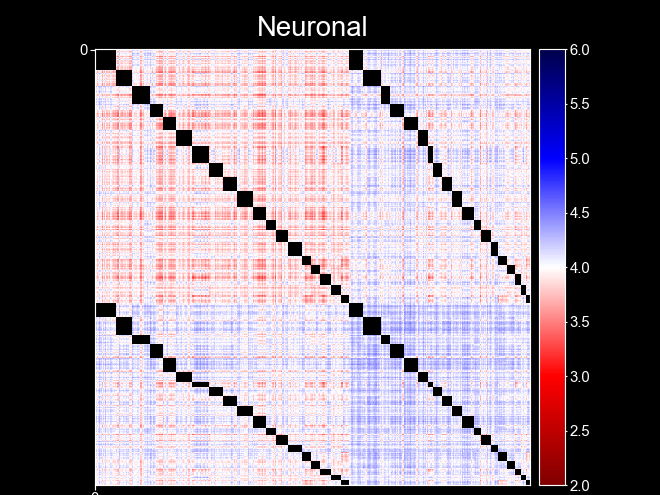

In [211]:
_type_matrix_file = os.path.join(r'\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\PostAnalysis\Nonnan_cutoff_100\Figures_Ex_Median_Trans_5000',
                                 r'trans-median_map_bychr_Neuronal.npy')
_type_matrix = np.load(_type_matrix_file)

_fig, _ax = plt.subplots(figsize=(4,3), dpi=150)
_ax = ia.figure_tools.distmap.plot_distance_map(
    _type_matrix[AB_inds, AB_inds[:,np.newaxis]]/1000, 
    color_limits=[2,6],
    font_size=6.5,
    ax=_ax,)
_ax.set_title(f"Neuronal")
_fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, top=0.9, bottom=0.02)


<IPython.core.display.Javascript object>


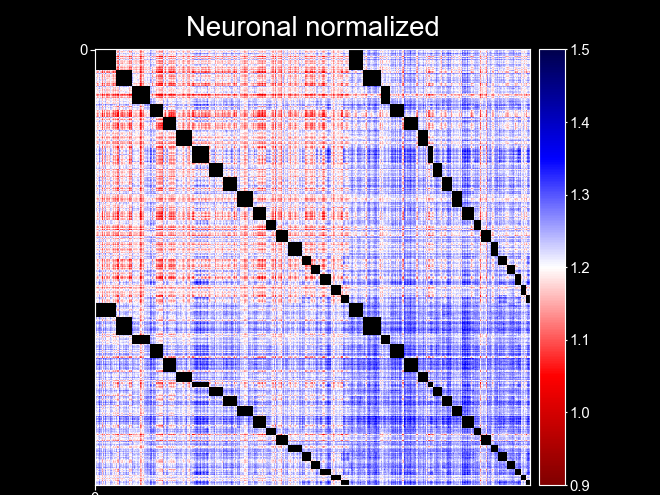

In [215]:
_type_matrix_file = os.path.join(r'\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\PostAnalysis\Nonnan_cutoff_100\Figures_Ex_Median_Trans_5000',
                                 r'trans-median_map_bychr_Neuronal_NORMALIZED.npy')
_type_matrix = np.load(_type_matrix_file)

_fig, _ax = plt.subplots(figsize=(4,3), dpi=150)
_ax = ia.figure_tools.distmap.plot_distance_map(
    _type_matrix[AB_inds, AB_inds[:,np.newaxis]], 
    color_limits=[0.9,1.5],
    font_size=6.5,
    ax=_ax,)
_ax.set_title(f"Neuronal normalized")
_fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, top=0.9, bottom=0.02)


<IPython.core.display.Javascript object>


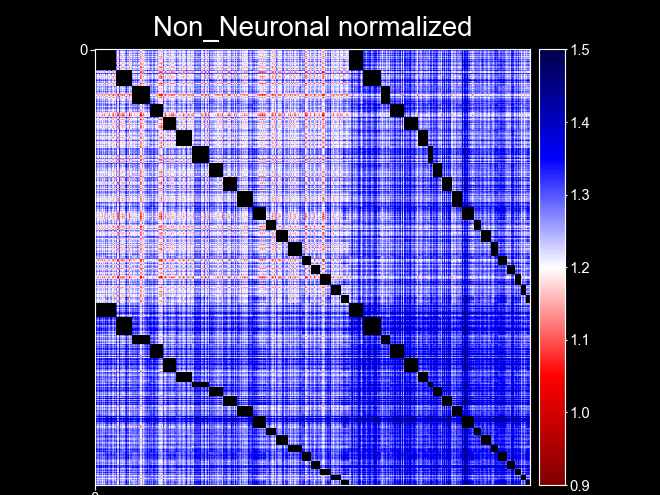

In [217]:
_type_matrix_file = os.path.join(r'\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\PostAnalysis\Nonnan_cutoff_100\Figures_Ex_Median_Trans_5000',
                                 r'trans-median_map_bychr_Non_Neuronal_NORMALIZED.npy')
_type_matrix = np.load(_type_matrix_file)

_fig, _ax = plt.subplots(figsize=(4,3), dpi=150)
_ax = ia.figure_tools.distmap.plot_distance_map(
    _type_matrix[AB_inds, AB_inds[:,np.newaxis]], 
    color_limits=[0.9,1.5],
    font_size=6.5,
    ax=_ax,)
_ax.set_title(f"Non_Neuronal normalized")
_fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.05, right=0.95, top=0.9, bottom=0.02)


In [218]:
from sklearn.neural_network import MLPClassifier

In [250]:
sel_inds = np.where(new_codebook['compartment'].values>=0)[0]
int_2_AB = {1:'A',0:'B'}
AB_vector = np.array([int_2_AB[_it] for _it in new_codebook['compartment'].values[sel_inds]])

In [251]:
AB_vector

array(['B', 'B', 'B', ..., 'A', 'B', 'B'], dtype='<U1')

In [254]:
_type_matrix_file = os.path.join(r'\\mendel\Mendel_SSD2\Pu_Temp\20220316-P_brain_CTP11-12-13_from_0304\PostAnalysis\Nonnan_cutoff_100\Figures_Ex_Median_Trans_5000',
                                 r'trans-median_map_bychr_Neuronal_NORMALIZED.npy')
_type_matrix = np.load(_type_matrix_file)


In [265]:
_mat = _type_matrix[sel_inds, sel_inds[:,np.newaxis]]
_mat[np.isnan(_mat)] = 1e-10

_X = _mat

_y = AB_vector

In [266]:
%%time
_clsf = MLPClassifier(random_state=1).fit(_X,_y)

Wall time: 8.75 s


In [268]:
_ny = _clsf.predict(_X)

In [269]:
np.mean(_ny ==_y)

0.5792811839323467

In [270]:
np.mean(_ny=='A')

0.39006342494714585

In [271]:
np.where(_ny=='A')

(array([  22,   23,   24,   25,   62,   63,   64,   73,   74,   75,   76,
          77,   78,   79,   94,   95,   96,   97,   98,   99,  100,  101,
         102,  103,  116,  117,  118,  130,  136,  137,  138,  139,  140,
         141,  142,  143,  144,  145,  146,  147,  148,  149,  150,  151,
         152,  296,  297,  298,  299,  300,  301,  302,  303,  304,  305,
         306,  307,  308,  309,  310,  311,  312,  313,  314,  315,  316,
         317,  318,  319,  320,  321,  322,  323,  324,  325,  326,  327,
         328,  329,  330,  331,  332,  333,  334,  335,  336,  337,  338,
         339,  340,  341,  342,  343,  344,  345,  346,  347,  348,  349,
         350,  351,  352,  353,  354,  355,  356,  357,  358,  359,  360,
         361,  362,  363,  364,  365,  366,  367,  368,  369,  370,  371,
         372,  373,  374,  375,  376,  377,  378,  379,  380,  381,  382,
         383,  384,  385,  386,  387,  388,  389,  390,  391,  392,  393,
         394,  395,  396,  397,  398, 

In [ ]:
_tempA = np.where(_ny=='A')
_tempB = np.where(_ny=='B')

A_inds = np.where(new_codebook['compartment'].values==1)[0]
B_inds = np.where(new_codebook['compartment'].values==0)[0]
AB_inds = np.concatenate([A_inds, B_inds])